# 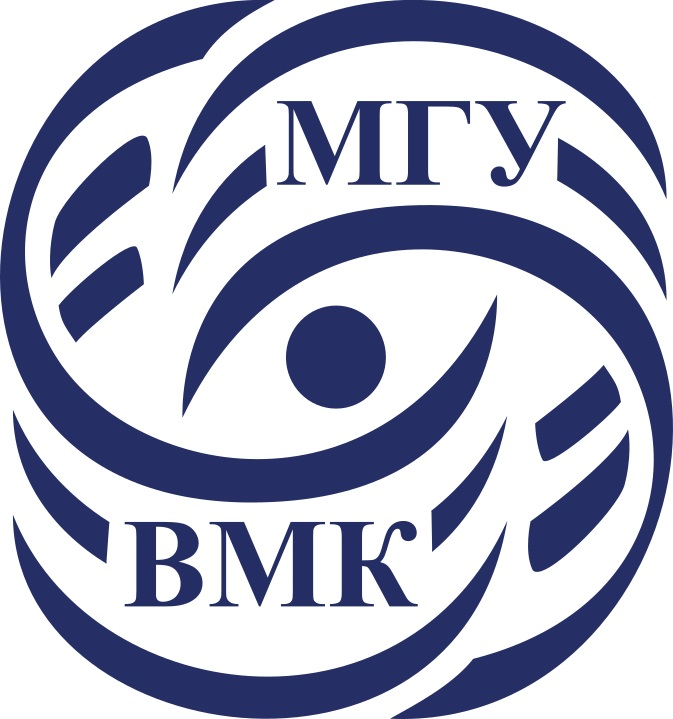

# Машинное обучение. ВМК МГУ

# Практическое задание 9: Случайные леса и отбор признаков
## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

__В этом задании вы:__

- Посмотрите, как выращивают случайные леса
- Проверите подвержены ли случайные леса переобучению
- Узнаете базовые методы отбора признаков

-------
<font color="white" style="opacity:0.2024"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 10 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [ ]:
# !!! Данный блок будет работать только в Google-Colab !!!
! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
! pip install -r /content/requirements_2024_25_for_colab_small.txt

Downloading...
From: https://drive.google.com/uc?id=10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
To: /content/requirements_2024_25_for_colab_small.txt
100% 375/375 [00:00<00:00, 1.11MB/s]


Проверим версию библиотеки:

In [ ]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2024"></font>

Привет, ребятушки!

Сегодня мы с вами посмотрим на такую вещь, как случайные леса. Мы попытаемся понять принцип их работы, пощупать, исследовать влияние параметров и, самое главное, узнаем, какое свойство случайных лесов оказало сильное влияние на машинное обучение.

Хочу обратить внимание, что в этом задании мы будем работать с регрессорами, однако все сделанные нами выводы верны также и для задач классификации.

<font color='OrangeRed'>**Внимание!**</font> Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка). Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

Для вычисления MAE можно использовать встроенную функцию `sklearn.metrics.mean_absolute_error`

Импортируем необходимые библиотеки:

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline # Если забыли, загляните в ноутбук Sklearn-knn-normalize-cv
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

#####
# если Вы не различаете предлагаемые цвета, то Вы можете раскомментить строку ниже
# для применения специальной цветовой палитры или аналогичных
# plt.style.use('tableau-colorblind10')
#####

import numpy as np

import time
import os

from itertools import combinations

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Загрузим датасет со стоимостью недвижимости в Калифорнии, который нам понадобится для первых заданий:

In [ ]:
def get_california_dataset():
    """Return the splits of the California housing dataset for training and testing"""
    X, y = fetch_california_housing(return_X_y=True)
    return train_test_split(X, y, random_state=42)

X_train, X_test, y_train, y_test = get_california_dataset()

# Случайные леса

Как многие из вас уже знают, [теорема Кондорсе о присяжных](https://neerc.ifmo.ru/wiki/index.php?title=%D0%92%D0%B8%D0%B4%D1%8B_%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B5%D0%B9#.D0.A2.D0.B5.D0.BE.D1.80.D0.B5.D0.BC.D0.B0_.D0.9A.D0.BE.D0.BD.D0.B4.D0.BE.D1.80.D1.81.D0.B5_.D0.BE_.D0.BF.D1.80.D0.B8.D1.81.D1.8F.D0.B6.D0.BD.D1.8B.D1.85), гласит, что если у нас имеется некоторое количество различных методов, каждый из которых предсказывает величину лучше, чем случайно, то голосование таких методов работает лучше, чем любой из этих методов по отдельности.

Данная идея отлично ложится на деревья решений. В теории для повышения дисперсии предсказаний каждого отдельного дерева можно ограничивать их глубину. На практике, помимо этого, также хорошо себя показало использование ограниченного набора признаков и данных. Это приводит нас к идее случайных лесов, о которых вы узнали на занятии.


### <font color='DarkOrange'>**Задание 1 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии   
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить 3 дерева решений, для каждого при инициализации установить `random_state` равный 1, 2 и 3. Ограничивать глубину деревьев не нужно.
1. Получить предсказание для тестовой выборки от каждого регрессора, а также получить ``усреднённое`` предсказание.
1. Посчитать MAE для каждого из деревьев, полученных в первом пункте, а также для усреднённых предсказаний. Сделать вывод о том, стало лучше или нет.

In [ ]:
tree_1 = DecisionTreeRegressor(random_state=1)
tree_2 = DecisionTreeRegressor(random_state=2)
tree_3 = DecisionTreeRegressor(random_state=3)

tree_1.fit(X_train, y_train)
tree_2.fit(X_train, y_train)
tree_3.fit(X_train, y_train)

y_pred_1 = tree_1.predict(X_test)
y_pred_2 = tree_2.predict(X_test)
y_pred_3 = tree_3.predict(X_test)
y_pred_mean = (y_pred_1 + y_pred_2 + y_pred_3) / 3

print("1. Качество первого дерева: ", mean_absolute_error(y_test, y_pred_1))
print("2. Качество второго дерева: ", mean_absolute_error(y_test, y_pred_2))
print("3. Качество третьего дерева: ", mean_absolute_error(y_test, y_pred_3))
print("4. Качество усредненных предсказаний: ", mean_absolute_error(y_test, y_pred_mean))

1. Качество первого дерева:  0.46331883139534885
2. Качество второго дерева:  0.4645068275193799
3. Качество третьего дерева:  0.46247640503875975
4. Качество усредненных предсказаний:  0.4542563636950904


<font color='MediumOrchid'>**Ваш ответ тут:**</font>

Качество у усредненного предсказания немного, но больше чем у каждого из трех деревьев, так как посчитанное MAE меньше у усредненного предсказания.

---

Надеюсь, мы смогли убедиться, что это хоть немного, но работает. Правда, улучшение достаточно маленькое и для прорыва в машинном обучении этого еще недостаточно.

А что влияет на улучшение, которое мы получаем при использовании ансамбля методов? Соответствующая теорема дает достаточно простой ответ: различность методов и ведет к улучшению. Если у нас есть много методов, предсказания которых отличаются незначительно, то их усреднение практически ничего не изменит. Если же у нас есть множество достаточно разных методов, то и их усреднение будет отличаться от предсказаний каждого отдельного метода. Видимо, random_state было недостаточно. Как же нам еще сильнее увеличить различность методов? Ответ вы знаете: использовать случайные признаки и случайную выборку объектов. Это приводит нас к случайным лесам, но с одним уточнением - случайные признаки отбираются не для отдельного дерева, а для конкретной вершины.

### <font color='DarkOrange'>**Задание 1.2 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии    
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучить `RandomForestRegressor`. Для честности следует установить ``n_estimators=3``, то есть сделать число деревьев равным 3 (как мы сделали в предыдущем задании). Для однородности также поставьте ``random_state = 0``
1. Посчитать MAE полученных предсказаний. Сравнить их с результатами, полученными в предыдущем пункте. Сделайте вывод.

In [ ]:
rf = RandomForestRegressor(n_estimators=3, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Качество random forest: ", mean_absolute_error(y_test, y_pred))

Качество random forest:  0.3910999521963824


**<font color='MediumOrchid'>Вывод по результату</font>**:

Случайный лес дает результат лучше по сравнению со средним предсказанием и с предсказанием отдельных деревьев.

---

Давайте изучим влияние числа деревьев на результат предсказаний.

### <font color='DarkOrange'>**Задание 1.3 [2 балла]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучите 10 случайных лесов, установив random_state=42 и замерив время, потраченное на обучение. Для обучаемых лесов, используйте число деревьев (`n_estimators`) из `np.logspace(1, 3, num=10)` (округлите значения вниз до целых чисел). Таким образом мы получим оценку результата для лесов, построенных с различным числом деревьев.
1. Для всех 10 лесов посчитайте MAE на тренировочном и тестовом множествах.
1. Постройте график для отображения зависимости времени обучения от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите время, потраченное на обучение.
1. Постройте еще один график для отображения зависимости значения MAE от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите одним цветом значение MAE на тренировочном множестве, другим цветом MAE на тестовом множестве.
1. Проанализируйте результаты и графики, сделайте выводы про время обучения при различном числе деревьев и про качество результатов (в частности - переобучение)

In [ ]:
estimators = np.floor(np.logspace(1, 3, num=10)).astype(int)
forest_time = []
forest_error_train = []
forest_error_test = []

for i in estimators:
  rf = RandomForestRegressor(n_estimators=i, random_state=42)
  start = time.time()
  rf.fit(X_train, y_train)
  forest_time.append(time.time() - start)
  pred_test = rf.predict(X_test)
  forest_error_test.append(mean_absolute_error(y_test, pred_test))
  pred_train = rf.predict(X_train)
  forest_error_train.append(mean_absolute_error(y_train, pred_train))


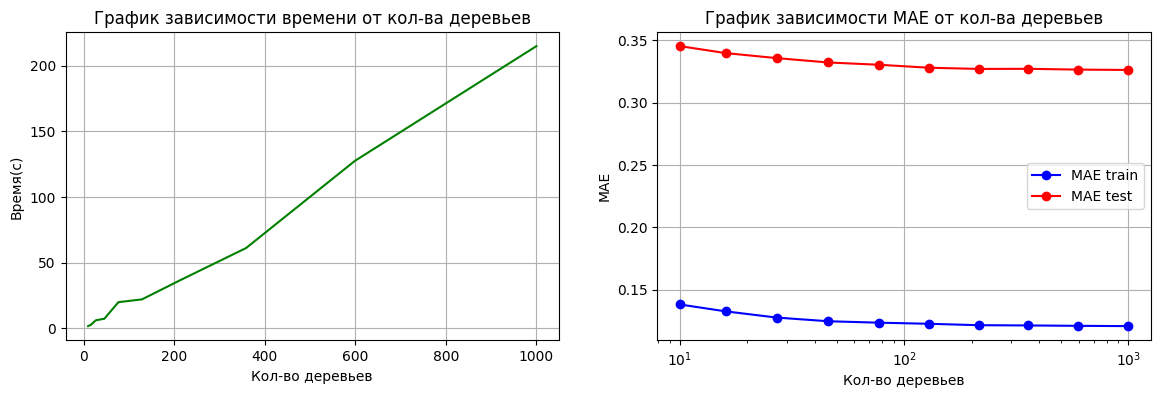

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(estimators, forest_time, color="green")
ax[0].set_xlabel("Кол-во деревьев")
ax[0].set_ylabel("Время(с)")
ax[0].set_title("График зависимости времени от кол-ва деревьев")
ax[0].grid()
ax[1].plot(estimators, forest_error_train, label="MAE train", color="blue", marker='o')
ax[1].plot(estimators, forest_error_test, label="MAE test", color="red", marker='o')
ax[1].set_title("График зависимости MAE от кол-ва деревьев")
ax[1].set_xlabel("Кол-во деревьев")
ax[1].set_ylabel("MAE")
ax[1].set_xscale('log')
ax[1].legend()
ax[1].grid()
plt.show()

**<font color='MediumOrchid'>Вывод по результату</font>**:

1. Время обучения зависит линейно от числа деревьев
2. Качество на обучающей выборке выше чем на тестовой
3. При увеличении числа деревьев качество улучшается как на тренировочной, так и на тестовой выборке
4. Увеличение числа деревьев не приводит к переобучению

----

Как мы с вами знаем, случайный лес постепенно улучшает качество предсказаний, увеличивая число деревьев в ансамбле. А что если мы уже обучили лес, но хотим `нарастить` его, добавив несколько деревьев? Или если к нам пришли новые данные и мы хотим добавить деревьев, обученных на них, но не удалять деревья, построенные на предыдущих данных? Такой трюк возможен, и для этого следует использовать warm_start. То, как правильно использовать `warm_start` можно глянуть [тут](https://stackoverflow.com/questions/42757892/how-to-use-warm-start/42763502)

### <font color='DarkOrange'>**Задание 1.4 [2 балла]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Создайте случайный лес со следующими параметрами: `n_estimators = 100, warm_start = True, random_state=42`
2. Обучите полученный лес, засекая время, потраченное на обучение, и измерив качество предсказания на тесте по MAE
3. Увеличьте число деревьев в лесу. Для этого увеличьте число `regressor.n_estimators` на 100.
4. Воспользуйтесь методом `fit`, чтобы дообучить новые деревья. Не забудьте замерить время и качество!
5. Повторяйте два предыдущих шага до тех пор, пока вы не вырастите лес с 1000 деревьями.
6. Постройте графики зависимости качества и времени обучения от количества деревьев (время считайте отдельно для каждого дообучения, без учета затрат на предыдущие итерации)
7. Проанализируйте результаты и графики, сделайте выводы про время обучения и качество, сравните с результатом из предыдущего пункта

In [ ]:
rf = RandomForestRegressor(n_estimators=100, warm_start = True, random_state=42)
forest_time = []
forest_error = []
estimators = list(range(100, 1001, 100))
for i in estimators:
  start = time.time()
  rf.fit(X_train, y_train)
  forest_time.append(time.time() - start)
  forest_error.append(mean_absolute_error(y_test, rf.predict(X_test)))
  rf.n_estimators += 100

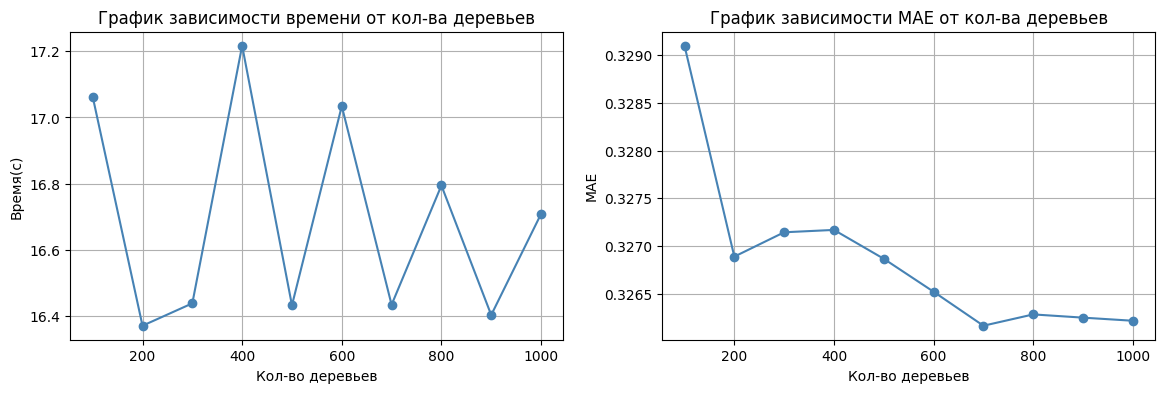

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(estimators, forest_time, color="steelblue", marker='o')
ax[0].set_xlabel("Кол-во деревьев")
ax[0].set_ylabel("Время(с)")
ax[0].set_title("График зависимости времени от кол-ва деревьев")
ax[0].grid()
ax[1].plot(estimators, forest_error, color="steelblue", marker='o')
ax[1].set_title("График зависимости MAE от кол-ва деревьев")
ax[1].set_xlabel("Кол-во деревьев")
ax[1].set_ylabel("MAE")
ax[1].grid()
plt.show()

**<font color='MediumOrchid'>Вывод по результату</font>**:

1. С добавлением деревьвев качество немного улучшается
2. Время дообучения не зависит от общего количества деревьев в лесу
3. Качество получилось лучше чем в прошлом пункте
4. По времени выгоднее добавлять деревья в обученную модель, чем с самого начала обучать случайный лес

# Отбор признаков

Теперь переключимся на несколько иную задачу. Представим, что нам нужно не только обучить какой-то метод, но и выделить наиболее полезные признаки (или, как минимум, удалить шумовые). Как мы можем это сделать? На самом деле, в машинном обучении есть просто огромное количество способов отбора признаков, и сейчас мы познакомимся с самимы популярными из них.

### L1 регуляризация

Как вы уже узнали из лекций, регуляризация помогает делать процесс обучения более робастным. Однако у L1 регуляризации есть один побочный эффект - она также способна занулять наименее информативные признаки. Давайте проверим этот эффект на практике.

### <font color='DarkOrange'>**Задание 2.1 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучите три линейных классификатора с L1 регуляризацией (`linear_model.Lasso`). Установите коэффициенты регуляризации `alpha` равными `0.1, 0.2 и 0.5.` Перед подачей признаков в Lasso, `нормализуйте признаки` (MinMax или StandardScaler на ваш выбор).
1. Обучите данные классификаторы на обучающем множестве.
1. Замерьте их качество на тесте, а также выведите количество ненулевых коэффициентов. Коэффициенты обученной линейной регрессии можно получить при помощи аттрибута `.coef_`
1. Выведите признаки, которые были занулены. Имена признаков можно найти в fetch_california_housing().feature_names
1. Сделайте выводы о способности LASSO отбирать признаки

In [ ]:
lin_model_1 = Lasso(alpha=0.1)
lin_model_2 = Lasso(alpha=0.2)
lin_model_3 = Lasso(alpha=0.5)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lin_model_1.fit(X_train_scaled, y_train)
lin_model_2.fit(X_train_scaled, y_train)
lin_model_3.fit(X_train_scaled, y_train)

y_pred_1 = lin_model_1.predict(X_test_scaled)
y_pred_2 = lin_model_2.predict(X_test_scaled)
y_pred_3 = lin_model_3.predict(X_test_scaled)

In [ ]:
feature_names = fetch_california_housing().feature_names

print("1. Качество модели с alpha=0.1: ", mean_absolute_error(y_test, y_pred_1))
print("   Количество ненулевых коэффициентов: ", np.sum(lin_model_1.coef_ != 0))
zero_features = [name for coef, name in zip(lin_model_1.coef_, feature_names) if coef == 0]
print("   Зануленные признаки:", zero_features)

print()
print("2. Качество модели с alpha=0.2: ", mean_absolute_error(y_test, y_pred_2))
print("   Количество ненулевых коэффициентов: ", np.sum(lin_model_2.coef_ != 0))
zero_features = [name for coef, name in zip(lin_model_2.coef_, feature_names) if coef == 0]
print("   Зануленные признаки:", zero_features)

print()
print("3. Качество модели с alpha=0.5: ", mean_absolute_error(y_test, y_pred_3))
print("   Количество ненулевых коэффициентов: ", np.sum(lin_model_3.coef_ != 0))
zero_features = [name for coef, name in zip(lin_model_3.coef_, feature_names) if coef == 0]
print("   Зануленные признаки:", zero_features)

1. Качество модели с alpha=0.1:  0.8920395728161894
   Количество ненулевых коэффициентов:  1
   Зануленные признаки: ['HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

2. Качество модели с alpha=0.2:  0.9100474990475331
   Количество ненулевых коэффициентов:  0
   Зануленные признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

3. Качество модели с alpha=0.5:  0.9100474990475331
   Количество ненулевых коэффициентов:  0
   Зануленные признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


**<font color='MediumOrchid'>Вывод по результату</font>**:

1. С увеличением значения alpha происходит большее зануление коэффициентов
2. Качество модели ухудшается с увеличением alpha
3. Lasso выбирает признаки слишком агрессивно, при alpha=0.1 важным оказался только один признак, при alpha=0.2 или 0.5 модель считает, что важных признаков нет, что не является верным, а значит Lasso выбирает важные признаки некачественно. Модель начинает слишком сильно сжимать коэффициенты, отбрасывает все признаки, что приводит к недообучению

Отлично! Мы убедились, что при помощи L1 регуляризации можно отбирать наиболее информативные признаки. Такой же трюк можно применять к svm, который может занулить признак, если ни один опорный объект не использует его.

Как мы помним, при помощи линейных классификаторов можно ранжировать признаки по важности, воспользовавшись соответствующими коэффициентами. Но перед этим нужно нормализовать используемые признаки, иначе значения коэффициентов невозможно будет сравнивать между собой.

Мы не зря начали данное задание со случайных лесов. Случайные леса также могут оценивать важность признаков! У каждого обученного леса есть аттрибут `feature_importances_.` Эти оценки рассчитываются на основе уменьшения критерия качества (например, Джини для классификации или среднеквадратичной ошибки для регрессии) при разделении узлов дерева на основе каждого признака. Чем сильнее увеличивается качество при использовании признака - тем он важнее.

 Данные значения уже отнормализованы и их можно использовать в явном виде для оценки важности признаков! Давайте воспользуемся этим.

### <font color='DarkOrange'>**Задание 2.2 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучите один случайный лес, установив`n_estimators=100`.
1. При помощи `rf.feature_importances_` найдите три признака, которые являются наиболее важными, а также три наименее важных признака. Выведите их названия.
1. Обучите обычную линейную регрессию `LinearRegressio`n на всех признаках, а также только на отобранных случайными лесами признаках. Не забывайте, что перед использованием линейной регрессии признаки нужно `отнормализовать`!

1. Сравните качество предсказаний и сделайте вывод о качестве выделенных признаков. Сравните с признаками, выделенными через LASSO.

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

features = rf.feature_importances_
feature_names = fetch_california_housing().feature_names
indices = np.argsort(features)
most_important = [feature_names[i] for i in indices[-3:]]
least_important = [feature_names[i] for i in indices[:3]]
print("Три наиболее важных признака: ", most_important)
print("Три наименее важных признака: ", least_important)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
most_important_features = indices[-3:]
X_train_important = X_train_scaled[:, most_important_features]
X_test_important = X_test_scaled[:, most_important_features]

lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
print("Качество линейной модели на всех признаках: ", mean_absolute_error(y_test,lin_model.predict(X_test_scaled)))

lin_model_imp = LinearRegression()
lin_model_imp.fit(X_train_important, y_train)
print("Качество линейной модели на важных признаках: ", mean_absolute_error(y_test, lin_model_imp.predict(X_test_important)))

Три наиболее важных признака: ['Latitude', 'AveOccup', 'MedInc']
Три наименее важных признака: ['AveBedrms', 'Population', 'AveRooms']
Качество линейной модели на всех признаках:  0.5296964012919453
Качество линейной модели на важных признаках:  0.6209129045339487


**<font color='MediumOrchid'>Вывод по результату</font>**:

1. Качество признаков, выделенных через случайный лес **лучше**, чем качество у LASSO, так как качество модели намного увеличилось
2. Качество модели на важны признаков **хуже** чем качество на всех признаках, так как сокращение признаков может уменьшает точность линейной модели.

---

До сих пор мы отбирали признаки по принципу удаления наименее информативных. Однако к данной задаче можно подойти с другого конца - добавлять признаки по 1, выбирая наиболее информативный из тех, что мы еще не использовали. Давайте посмотрим, что мы получим при помощи такой стратегии.

Кратко, данную стратегию можно описать следующим псевдокодом:

1. Инициализировать список выбранных признаков (пустой)  
2. Инициализировать список оставшихся признаков (все доступные)  
3. Пока выбранное число признаков меньше необходимого:  
   3.1 Для каждого признака из оставшихся:  
      - Добавить его к текущему списку выбранных  
      - Обучить модель на этих признаках  
      - Вычислить ошибку на тестовых данных  
      
   3.2 Добавить признак с наименьшем значением ошибки в пункте 3.1 в список выбранных

   3.3 Удалить его из списка оставшихся  

4. Вернуть список лучших признаков  


### <font color='DarkOrange'>**Задание 2.3 [2 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Реализуйте процесс отбора признаков путем добавление одного наиболее информативного признака. Воспользуйтесь `DecisionTreeRegressor` в качестве базового классификатора.
1. Отберите 3 наиболее важных признака
1. Обучите обычную линейную регрессию на всех признаках, а также только на отобранных признаках. Сравните качество предсказаний и сделайте вывод о качестве выделенных признаков. Сравните с признаками, выделенными в предыдущем задании.

In [ ]:
def select_best_features(X_train, X_test, y_train, y_test, max_features=3):
    feature_names = fetch_california_housing().feature_names
    feat_last = list(range(len(feature_names)))
    best_features = []
    best_best_features = []
    while max_features > 0 and feat_last:
        error = float("inf")
        best_candidate = None
        feat = best_best_features.copy()
        for i in feat_last:
            candidate_features = best_features + [i]
            X_imp = X_train[:, candidate_features]
            tree = DecisionTreeRegressor()
            tree.fit(X_imp, y_train)
            X_imp_test = X_test[:, candidate_features]
            mae = mean_absolute_error(y_test, tree.predict(X_imp_test))
            if mae < error:
                error = mae
                best_candidate = i
        if best_candidate is not None:
            best_features.append(best_candidate)
            feat_last.remove(best_candidate)
        max_features -= 1
    best_best_features = best_features
    feat_names = [feature_names[i] for i in best_best_features]
    print("Выбранные признаки:", feat_names)
    return best_best_features

In [ ]:
best_best_features = select_best_features(X_train, X_test, y_train, y_test)
X_train_imp = X_train[:, best_best_features]
X_test_imp = X_test[:, best_best_features]
linear_model_1 = LinearRegression()
linear_model_2 = LinearRegression()
linear_model_1.fit(X_train, y_train)
linear_model_2.fit(X_train_imp, y_train)
y_pred_1 = linear_model_1.predict(X_test)
y_pred_2 = linear_model_2.predict(X_test_imp)
print("1. Качество линейной регрессии на всех признаках: ", mean_absolute_error(y_test, y_pred_1))
print("2. Качество линейной регрессии на отобранных признаках: ", mean_absolute_error(y_test, y_pred_2))

Выбранные признаки: ['Longitude', 'Latitude', 'MedInc']
1. Качество линейной регрессии на всех признаках:  0.5296964012919742
2. Качество линейной регрессии на отобранных признаках:  0.545541698929113


**<font color='MediumOrchid'>Вывод по результату</font>**:

Качество на признаках, выбранных путем добавлением одного наиболее информативного признака, получилось выше чем в пунктах ранее. Следовательно этот метод выбирает наиболее важные признаки, чем способы выше.